# 10. PyTorch Model Deployment

What is model deployment?

The act of making the ML model we trained be accessible by someone or somthing else

## 0. Get Setup

## 1.Getting Data

The dataset we are going to use for deploying a FoodVision Mini model is.....

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101 and only 20% of the samples)

In [1]:
import torch
import torchvision

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiement outline

### 3 questions for ML deployment
1. What is the most ideal machine learning deployment scenario
2. Where is the model going to go?
3. How is the model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

- Performs well: 95+% accuracy
- Fast: as close to real-time or faster: 30 FPS (30ms)
  - Latency: time for prediction to take place

To try and achieve these goals, we are going to build 2 model experiements:
1. EffNetB2 feature extractor
2. ViT feature extractor

## 3. Creating an EffNetB2 feature extractor

Feature extractor -> A term for a transfer learning model that has it's base layers frozen and output layers/head layers customized to a certain problem.

In [6]:
from torchvision import models

# 1. Get the model with Default weights
effnetb2_weights = models.EfficientNet_B2_Weights.DEFAULT

# 2. Get the transforms form EffNetB2
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrianed models
effnetb2 = models.efficientnet_b2(weights='DEFAULT')

# 4. Freeze the base layers in the model (stop feature layer from training)
for params in effnetb2.features.parameters():
  params.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 186MB/s]


In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# SEt seeds for reproducibility
set_seeds()

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

### 3.1 Creating a function to make an EFFNETB2 feature extractor

In [9]:
def create_effnetb2_model(num_classes: int=3,
                          seed:int=42):
  import torchvision
  from torchvision import models

  # Set seeds
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # Get weights of model
  weights = models.EfficientNet_B2_Weights.DEFAULT

  # Get the transfroms
  effnetb2_transforms = weights.transforms()

  # Get model
  model = models.efficientnet_b2(weights=weights)

  # Freeze the feature layers
  for params in model.features.parameters():
    params.requires_grad = False

  # Replace classifier
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  #return the transfroms and the model
  return model, effnetb2_transforms

In [10]:
from torchinfo import summary

summary(
    model=effnetb2,
    col_names=['input_size','output_size','num_params','trainable'],
    col_width=20,
    row_settings=['var_names'],
    input_size=(1,3,224,224)
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating DataLoaders for EffNetB2

In [12]:
# Seupt DataLoaders
from going_modular.going_modular.data_setup import create_dataloaders

train_datalaoder_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

len(train_datalaoder_effnetb2), len(test_dataloader_effnetb2), len(class_names)

(15, 5, 3)

### 3.3 Training EffNetB2 feature extractor


In [13]:
from going_modular.going_modular.engine import train

# Loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()

effnetb2_results = train(
    train_dataloader=train_datalaoder_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device,
    model=effnetb2,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9430 | train_acc: 0.6208 | test_loss: 0.7432 | test_acc: 0.9199
Epoch: 2 | train_loss: 0.6845 | train_acc: 0.8500 | test_loss: 0.5986 | test_acc: 0.8920
Epoch: 3 | train_loss: 0.5795 | train_acc: 0.8562 | test_loss: 0.5014 | test_acc: 0.9352
Epoch: 4 | train_loss: 0.4400 | train_acc: 0.9083 | test_loss: 0.4434 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4216 | train_acc: 0.9062 | test_loss: 0.4053 | test_acc: 0.9261
Epoch: 6 | train_loss: 0.4262 | train_acc: 0.8938 | test_loss: 0.3634 | test_acc: 0.9352
Epoch: 7 | train_loss: 0.4218 | train_acc: 0.8375 | test_loss: 0.3361 | test_acc: 0.9290
Epoch: 8 | train_loss: 0.3936 | train_acc: 0.9021 | test_loss: 0.3587 | test_acc: 0.9261
Epoch: 9 | train_loss: 0.3723 | train_acc: 0.8833 | test_loss: 0.3219 | test_acc: 0.9227
Epoch: 10 | train_loss: 0.3680 | train_acc: 0.8646 | test_loss: 0.2872 | test_acc: 0.9688


### 3.4 Inspect the EffNetB2 loss curves

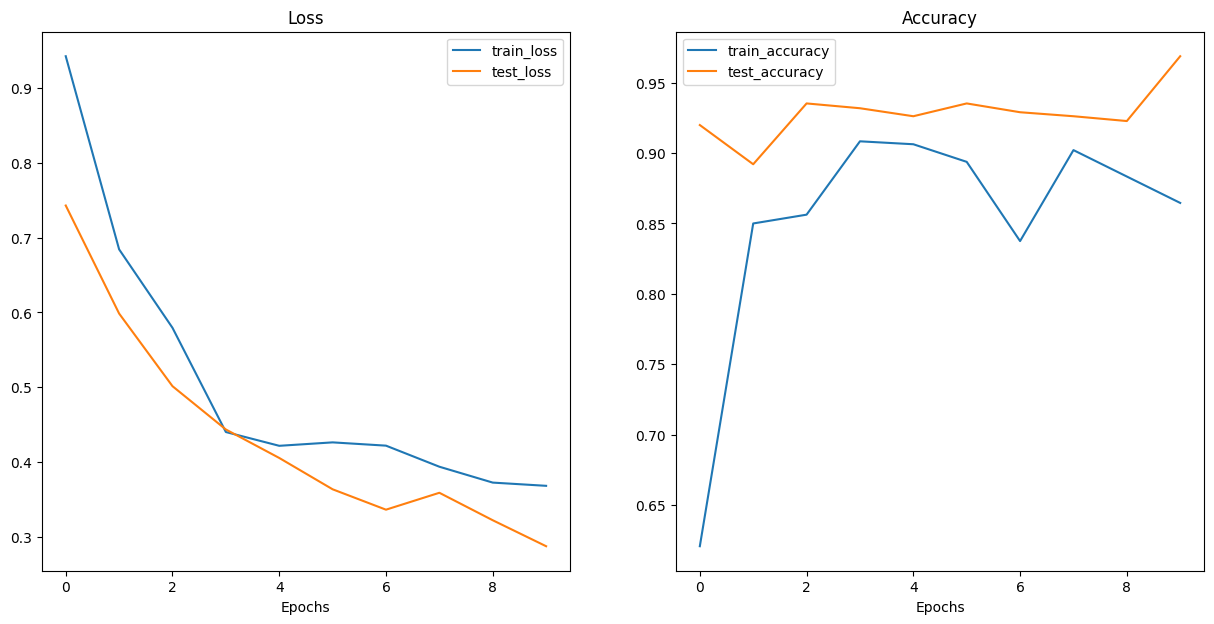

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Save EffNetB2 feature extractor

In [15]:
from going_modular.going_modular.utils import save_model

# Save the model
save_model(model=effnetb2,
                 target_dir='models',
                 model_name='Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature Extractor

Why do need to consider the size of the saved model?

If we would like to deploy the model on a mobile device or a browser, there might be limited compute resouces -> Hence we may not be able to save it/ run it

In [16]:
from pathlib import Path

effnetb2_size = Path('models/Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024*1024)
print(f'EffNetB2 model size: {effnetb2_size:.2f} MB')

EffNetB2 model size: 29.86 MB


### 3.7 Collection EffNetB2 Feature Extractor Stats

In [17]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(params) for params in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    'test_loss': effnetb2_results['test_loss'][-1],
    'test_acc': effnetb2_results['test_acc'][-1],
    'number_of_paramebters': effnetb2_total_params,
    'model_size (MB)': effnetb2_size,
}
effnetb2_stats

{'test_loss': 0.28715840280056,
 'test_acc': 0.96875,
 'number_of_paramebters': 7705221,
 'model_size (MB)': 29.862421989440918}

## 4.0 Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time for ViT

### 4.1 Creating a function to make ViT-Base feature extractor

In [19]:
def create_vit_model(num_classes: int=3,
                     seed: int=42):
  # Set seeds for reproducibility
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

  # Get the weights
  weights = models.ViT_B_16_Weights.DEFAULT

  # Get the transfroms
  vit_transforms = weights.transforms()

  # Get the pretrained vit model
  model = models.vit_b_16(weights=weights)

  # Freeze all layers and replace the head
  for params in model.parameters():
    params.requires_grad=False

  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes, bias=True)
  )

  return model, vit_transforms

In [20]:
vit, vit_transfroms = create_vit_model()
vit.heads

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


Sequential(
  (0): Linear(in_features=768, out_features=3, bias=True)
)

In [21]:
summary(
    model=vit,
    col_names=['input_size','output_size','num_params','trainable'],
    col_width=20,
    row_settings=['var_names'],
    input_size=(1,3,224,224)
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.2 Creaing DataLoaders for ViT-Base

In [22]:
train_datalaoder_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transfroms,
    batch_size=32
)
len(train_datalaoder_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.3 Training ViT-Base feature extractor


In [23]:
# Loss functions
loss_fn = nn.CrossEntropyLoss()

#Choose Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),lr=1e-3)

# Set seeds
set_seeds()

vit_results = train(
    model=vit,
    train_dataloader=train_datalaoder_vit,
    test_dataloader=test_dataloader_vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6470 | train_acc: 0.8208 | test_loss: 0.2180 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.2491 | train_acc: 0.9208 | test_loss: 0.1354 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1708 | train_acc: 0.9667 | test_loss: 0.1040 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1253 | train_acc: 0.9688 | test_loss: 0.0882 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1121 | train_acc: 0.9708 | test_loss: 0.0778 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.1283 | train_acc: 0.9458 | test_loss: 0.0698 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0898 | train_acc: 0.9792 | test_loss: 0.0746 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0968 | train_acc: 0.9833 | test_loss: 0.0645 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0881 | train_acc: 0.9854 | test_loss: 0.0616 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0664 | train_acc: 0.9875 | test_loss: 0.0555 | test_acc: 1.0000


### 4.4 Inspect the Vit-Base loss curves

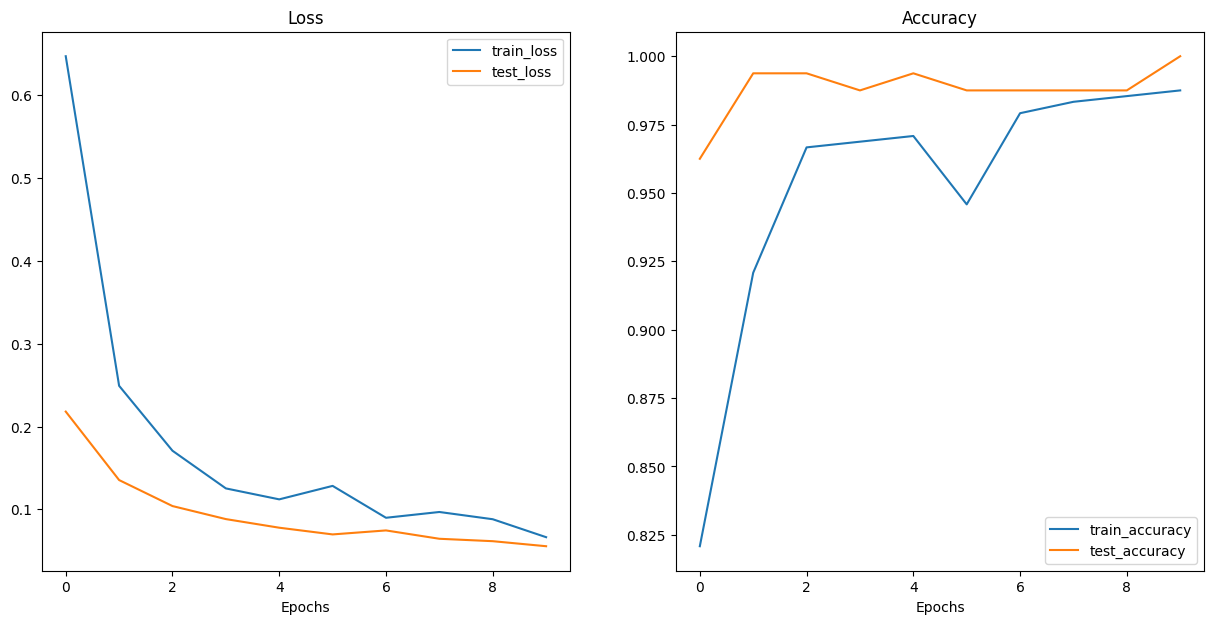

In [24]:
plot_loss_curves(vit_results)

### 4.5 Save ViT-Base Feature Extractor

In [25]:
# from helper_functions import save_model

save_model(
    model=vit,
    target_dir='models',
    model_name='Pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth'
)

[INFO] Saving model to: models/Pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.6 Inspecting the size of the ViT-Base model

In [26]:
from pathlib import Path

vit_size = Path('models/Pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size / (1024 * 1024)

print(f'ViT-Base model size: {vit_size:.2f} MB')

ViT-Base model size: 327.37 MB


### 4.7 Collection of ViT Feature Extractor Stats

In [27]:
vit_num_params = sum(torch.numel(params) for params in vit.parameters())

# Create a dictionary with EffNetB2 statistics
vit_stats = {
    'test_loss': vit_results['test_loss'][-1],
    'test_acc': vit_results['test_acc'][-1],
    'number_of_paramebters': vit_num_params,
    'model_size (MB)': vit_size,
}
vit_stats

{'test_loss': 0.0555019048973918,
 'test_acc': 1.0,
 'number_of_paramebters': 85800963,
 'model_size (MB)': 327.3710660934448}

## 5. Making Predictions with our trained models and timing them

Our goal:
1. Performs well (95+% test accuracy)
2. Infer Fast (30FPS+)

To test criteria 2:
1. Loop through the test images
2. Time how long each model takes to make a prediciton on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test images paths.

In [28]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:3]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/697562.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

1. Create a function that takes a list of paths and a trained PyTorch model, a series of transfomrs, a list of target class names and a target device
2. Create a empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will be inside the loop)
4. Create an empty dictionary for each sample (prediction stats will go in here).
5. Get the sample path and ground truth class from pathlib
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and truning on `torch.inference()`
10. On `eval()`, pass the transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4
12. End predcition timer started in 6, and add the time to the prediction dictrionary
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predcition we created in step 2
15. Return the list of prediction dictionaries

In [29]:
from typing import List, Dict
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pathlib

# 1. Create a function that takes a list of paths and a trained PyTorch model, a series of transfomrs, a list of target class names and a target device
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   device: str='cuda' if torch.cuda.is_available() else 'cpu',
                   class_names: List[str]=class_names,
                   transform: torchvision.transforms=vit_transfroms) -> List[Dict]:

  # 2. Create a empty list (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will be inside the loop)
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction stats will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from pathlib
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # 6. Start the prediction timer.
    start_time = timer()

    # 7. Open the image using PIL.Image.open(path)
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model.
    transformed_img = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending it to the target device and truning on torch.inference()
    model = model.to(device)
    model.eval()

    # 10. On eval(), pass the transformed image to the model and perform forward pass + calculate pred prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_img)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1) # Trun prediction probabilities  into labels
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python varibales live on CPU)

    # 11. Add the pred prob + pred class to empty dictionary from step 4
    pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4 )
    pred_dict['pred_class'] = pred_class

    # 12. End predcition timer started in 6, and add the time to the prediction dictrionary
    end_time = timer()
    pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict['correct'] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predcition we created in step 2
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

We will run the `pred_and_store()` function.

2 Things to note:
1. Device - we're going to hardcode our predictions to happen to CPU (because you won't always be sure of having a GPU when you deploy your model)
2. Transforms - we want to ensure the images are transformed on the appropriate ways before the predictions

In [30]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dict = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    device='cpu',
    transform=effnetb2_transforms,
    class_names=class_names
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
effnetb2_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9408,
  'pred_class': 'steak',
  'time_for_pred': 0.3434,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/697562.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7055,
  'pred_class': 'steak',
  'time_for_pred': 0.1358,
  'correct': True}]

In [32]:
# Turn the list of dictionary into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9408,steak,0.3434,True
1,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.7055,steak,0.1358,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6261,steak,0.0992,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8813,steak,0.0889,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8870,steak,0.1098,True


In [33]:
# Check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,145
False,5


In [34]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f'Average Time per prediction: {effnetb2_average_time_per_pred*1000} ms')

Average Time per prediction: 114.0 ms


In [35]:
# Add time per pred to EffNetB2 stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28715840280056,
 'test_acc': 0.96875,
 'number_of_paramebters': 7705221,
 'model_size (MB)': 29.862421989440918,
 'time_per_pred_cpu': np.float64(0.114)}

> **Note:** Prediction times will vary (much like training times) depending on the hardware being used.

Faster GPU -> Faster Predictions
>

### 5.3 Making and timeing predictions for ViT-Base

In [36]:
vit_test_pred_dict = pred_and_store(
    model=vit,
    paths=test_data_paths,
    device='cpu',
    class_names=class_names,
    transform=vit_transfroms
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
vit_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9942,
  'pred_class': 'steak',
  'time_for_pred': 0.7707,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/697562.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8443,
  'pred_class': 'steak',
  'time_for_pred': 0.3468,
  'correct': True}]

In [38]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dict)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9942,steak,0.7707,True
1,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.8443,steak,0.3468,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9892,steak,0.4544,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9786,steak,0.4013,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9734,steak,0.4029,True


In [39]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,150


In [40]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f'Average time per prediction of ViT-Base {vit_average_time_per_pred*1000} ms')

Average time per prediction of ViT-Base 561.4 ms


In [41]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred

In [42]:
vit_stats

{'test_loss': 0.0555019048973918,
 'test_acc': 1.0,
 'number_of_paramebters': 85800963,
 'model_size (MB)': 327.3710660934448,
 'time_per_pred_cpu': np.float64(0.5614)}

## 6. Comparing model results, prediction times and size

In [43]:
# Trun stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model name
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc']*100, 2)

df

,test_loss,test_acc,number_of_paramebters,model_size (MB),time_per_pred_cpu,model
0,0.287158,96.88,7705221,29.862422,0.1140,EffNetB2
1,0.055502,100.00,85800963,327.371066,0.5614,ViT


Which model is better?

- `test_loss` (lower is better) - ViT
- `test_acc` (higher is better) - ViT
- `number_of_parameters` (generally lower is better) - EffNetB2
  - Usually number of parameters is directly correlated to model size, but sometimes the else is true
- `model_size (MB)` - EffNetB2 (for our use case for deploying on mobile or web-browser)
- `time_per_pred_cpu` (lower is better) - EffNetB2  
  - Will be highly dependant on the hardware it is run on

Both models failed to achieve our goal of 30+FPS..

In [44]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(df.set_index('model').loc['ViT']/df.set_index('model').loc['EffNetB2'],
             columns=['ViT to EffNetB2 rations']).T

,test_loss,test_acc,number_of_paramebters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 rations,0.19328,1.032205,11.135432,10.962643,4.924561


### 6.1 Visualizing the speed vs. performance tradeoff

So we ahve compared our EffNetB2 and ViT feature extractor models, now let us visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's gong on.
4. Create a legend based on the model sizes (`model_size (MB)`)

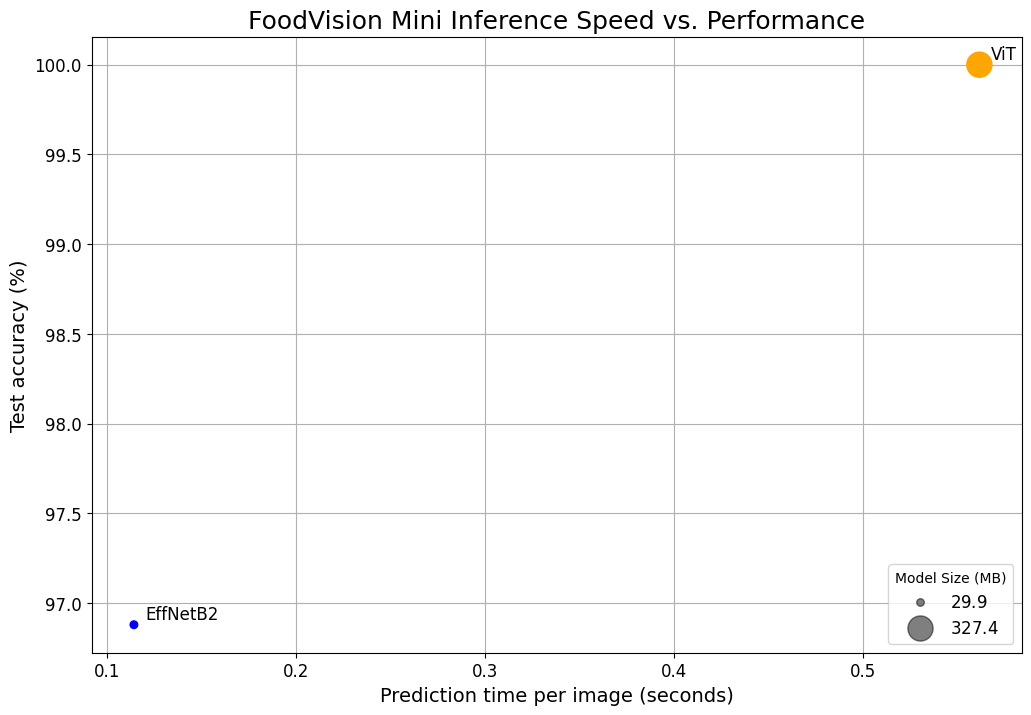

In [45]:
# Create a Plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')

# Add titles and labels to make our plot look good
ax.set_title('FoodVision Mini Inference Speed vs. Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# Annotatte the samples on teh scatter plot so we know what is what
for index, row in df.iterrows():
  ax.annotate(text=row['model'],
              xy=(row['time_per_pred_cpu']+0.006, row['test_acc']+0.03),
              size=12,
              )

# Create a legend based on the model sizes
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title = 'Model Size (MB)',
                              fontsize=12)

# Save the figure
plt.savefig('09_foodvision-mini-inference-speed-vs-performance.png')

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our creteria the best.

What is Gradio?

> Fasted way to demo ML model with a friendly web interface so that anyone can access it

In [46]:
!pip -q install gradio
import gradio as gr

### 7.1 Gradio Overview

Gradio helps one create ML demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradion is to map: inputs -> ML model -> outputs

### 7.2 Creat a function to map our inputs and outputs

In [47]:
# Put the model o the CPU
effnetb2 = effnetb2.to('cpu')

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> output (food class labels, prediction time)
```

In [48]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_img = effnetb2_transforms(img).unsqueeze(0) # Add a batch dimension

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_logits = effnetb2(transformed_img)
    pred_probs = pred_logits.softmax(dim=1)
    pred_label = pred_probs.argmax(dim=1)

  # Create a prediciton label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [49]:
import random
from PIL import Image

# Get a list of all test image file paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# Randomly select a image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f'[INFO] Predicting on image at path: {random_image_path}')

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)

print(f'Prediction probs: {pred_dict}')
print(f'Prediciton time: {pred_time}')

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg
Prediction probs: {'pizza': 0.737463653087616, 'steak': 0.15905286371707916, 'sushi': 0.1034834161400795}
Prediciton time: 0.0956


### 7.3 Creating a list of images

The examples for gradio can be created with the `examples` parameter

In [50]:
# Create a list of example inputs to our Gradio Demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/86782.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transfroms -> predict with EffNetB2 -> prediction probabilities , prediction time
```

In [51]:
import gradio as gr

# Create title, description and article
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi.'
article = 'Created as a part of PyTorch Course'

# Create the Gradio demo
demo = gr.Interface(
    fn=predict, # maps inpout to outputs
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
            gr.Number(label='Predicion time (s)')], # Top 3 -> the order of them in the dataset
    examples=example_list,
    title=title,
    description=description,
    article=article,
    )

# Launch the demo
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63b2e74f0c60bd995c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expire within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spacces

### 8.1 What is Hugging Space

Is a way to host ML devolopement and deploy it for showcasing and collaboration

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine Learning ability (Through the ML you have built)

### 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```

By the end the file structure should look like:

``` python
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py # Default python app which will be deployed
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py # Model architecture and loading
    └── requirements.txt
```

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [52]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini')

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we need:
- 3 images in an `examples/` director
- Images should be the test set

In [53]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the 3 images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  shutil.copy2(src=example,dst=destination)
  print(f'[INFO] Copying {example} to {destination}')

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory.

In [54]:
import os

# Get example filepaths in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [55]:
import shutil

# Create a soruce path for our target model
effnetb2_foodvision_mini_model_path = 'models/Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth'

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

# Move the model file
try:
  print(f'[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}')

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f'[INFO] Model move complete')
except:
  # IF the model has already been moved, check if it exists
  print(f'[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?')
  print(f'[INFO] Model exists at destination {effnetb2_foodvision_mini_model_path}: {effnetb2_foodvision_mini_model_destination.exists()}')

[INFO] Attempting to move models/Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete


### 8.6 Truning our EffNetB2 model into Python script (`model.py`)

Let's move our `create_effnetb2_model()` function to a script so we can resue it

In [56]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=3,
                          seed:int=42):
  import torchvision
  from torchvision import models

  # Set seeds
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # Get weights of model
  weights = models.EfficientNet_B2_Weights.DEFAULT

  # Get the transfroms
  effnetb2_transforms = weights.transforms()

  # Get model
  model = models.efficientnet_b2(weights=weights)

  # Freeze the feature layers
  for params in model.features.parameters():
    params.requires_grad = False

  # Replace classifier
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  #return the transfroms and the model
  return model, effnetb2_transforms

Writing demos/foodvision_mini/model.py


In [57]:
from demos.foodvision_mini.model import create_effnetb2_model

effnetb2_model, effnetb2_model_transforms = create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 8.7 Turning the FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` will have 4 major parts:
- Imports and class name setup
- Model and transforms preparation
- Predict function (`predict`)
- Gradio app - Gradio interface + launch command

In [58]:
class_names

['pizza', 'steak', 'sushi']

In [59]:
%%writefile demos/foodvision_mini/app.py
### 1. Import and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transfroms preparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names),
)

# Load saved weights
effnetb2.load_state_dict(torch.load(f'Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth',
                                    map_location=torch.device('cpu') # Always load the model back to the CPU -> else error if no GPU not present
                                  ))

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_img = effnetb2_transforms(img).unsqueeze(0) # Add a batch dimension

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_logits = effnetb2(transformed_img)
    pred_probs = pred_logits.softmax(dim=1)
    pred_label = pred_probs.argmax(dim=1)

  # Create a prediciton label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = 'FoodVision Mini 🍕🥩🍣'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi.'
article = 'Created as a part of PyTorch Course'

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Create the Gradio demo
demo = gr.Interface(
    fn=predict, # maps inpout to outputs
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
            gr.Number(label='Predicion time (s)')], # Top 3 -> the order of them in the dataset
    examples=example_list,
    title=title,
    description=description,
    article=article,
    )

# Launch the demo
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for foodvision mini (`requirements.txt`)

The requirement file will tell our Hugging Face Space what software dependencies our app needs.

- `torch`
- `torchvision`
- `gradio`

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.9.0
torchvision==0.24.0
gradio==5.50.0

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app HuggingFace spaces

## 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces

In [61]:
!ls demos/foodvision_mini

app.py	  Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth
examples  __pycache__
model.py  requirements.txt


In [62]:
# Chane into the foodvision_mini directory and zip it from the inside
!cd demos/foodvision_mini/ && zip -r ../foodvision_mini.zip * -x '*.pyc' '*.ipynb' '*__pychache__*' '*ipynb_checkpoints*'

  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: Pretrained_effnet2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: __pycache__/ (stored 0%)
  adding: requirements.txt (deflated 12%)


In [63]:
# Download
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print(f'Not running in Google Colab, download it manually')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running the Gradio demo app locally

```
If you download the foodvision_mini.zip file, you can test it locally by:

    Unzipping the file.
    Opening terminal or a command line prompt.
    Changing into the foodvision_mini directory (cd foodvision_mini).
    Creating an environment (python3 -m venv env).
    Activating the environment (source env/bin/activate).
    Installing the requirements (pip install -r requirements.txt, the "-r" is for recursive).
        Note: This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade pip first: pip install --upgrade pip.
    Run the app (python3 app.py).

This should result in a Gradio demo just like the
```

### 9.3 Uploading the files to HuggingFace Spaces

In [64]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src='https://huggingface.co/spaces/Ghengiskhan/FoodVision_Mini', width=900, height=750)

## 10. Creating FoodVision Big!!!

FoodVision Mini works well with 3 classes (pizza, steak, sushi).

So all the experiments so far have been paying off..

So we will continue to make FoodVision BIG!! using all 101 classes from Food101

### 10.1 Creating a model for FoodVision Big + transforms

In [65]:
# Create big effnetb2 model and transfomrs
effnetb2_food101, effnetb2_food101_transforms = create_effnetb2_model(num_classes=101)

In [66]:
summary(
    model=effnetb2_food101,
    col_names=['input_size','output_size','num_params','trainable'],
    col_width=20,
    row_settings=['var_names'],
    input_size=(1,3,224,224)
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since we are working with a large dataset, we would need to introduce some data augmentation techniques:
- This is because with larger datasets and larger models, overfitting becomes more of a problem.
- As we have many many classes, let us use the TrivialAugment as the data augmentation techniques

In [67]:
effnetb2_food101_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [68]:
food_101_transforms = torchvision.transforms.Compose([
    transforms.TrivialAugmentWide(),
    effnetb2_food101_transforms
])

In [69]:
food_101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [70]:
# Test data transform
effnetb2_model_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

Get Food101 Dataset from PyTorch

In [71]:
from pathlib import Path

# Setup data directory

food101_data_path = Path('data/food101')
food101_train_dir = food101_data_path / 'train'
food101_test_dir = food101_data_path / 'test'
food101_test_dir, food101_train_dir

(PosixPath('data/food101/test'), PosixPath('data/food101/train'))

In [72]:
# Get the training data
train_data = torchvision.datasets.Food101(root=food101_train_dir, split='train',download=True, transform=food_101_transforms)

100%|██████████| 5.00G/5.00G [03:59<00:00, 20.9MB/s]


In [73]:
test_data = torchvision.datasets.Food101(root=food101_test_dir, split='test', download=True, transform=effnetb2_model_transforms)

100%|██████████| 5.00G/5.00G [03:56<00:00, 21.1MB/s]


In [74]:
# Get the food101 classes
food101_class_names = train_data.classes
food101_class_names[:10] # View first 10

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of Food101 dataset for faster experimenting

Why create a subnet?

We want our fist few experiments to run as quick as possible.

We know FoodVisionMini works pretty well but this is the first time we are upgrading to 101 classes.

So make a subset of 20% data from the food101 dataset

Goal: To beat the original food101 paper result of 56.4% accuracy on the test dataset (see the paper)

We want to beat this result using modern deep learning techniques and only 20% of the data

In [75]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed=42):
  # Create split lengths based on orginal dataset length
  length_1 = int(len(dataset)* split_size)
  length_2 = len(dataset) - length_1 # Remaining length

  # Print out info
  print(f'[INFO] Splitting dataset of length {len(dataset)} into {length_1} and {length_2}')

  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1,length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [76]:
# Create 20 percent of train data
train_data_food101_20_percent, _ = split_dataset(train_data, 0.2)

# Create 20 percent of test data
test_data_food101_20_percent, _ = split_dataset(test_data, 0.2)

[INFO] Splitting dataset of length 75750 into 15150 and 60600
[INFO] Splitting dataset of length 25250 into 5050 and 20200


In [77]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoader`s

In [78]:
from torch.utils.data import DataLoader

batch_size = 32

# Create Food101 20 training dataloader
train_dataloader_food101_20 = DataLoader(
    dataset=train_data_food101_20_percent,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Create Food101 20 testing dataloader
test_dataloader_food101_20 = DataLoader(
    dataset=test_data_food101_20_percent,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

In [79]:
len(train_dataloader_food101_20), len(test_dataloader_food101_20)

(474, 158)

### 10.5 Training FoodVision Big!!

We will use hyperparameters of:

- 5 epochs
- Optimizer: `torch.optim.Adam(lr=le-3)
- loss_fn : nn.CrossEntropyLoss(label_smoothing=0.1) -> used for regularization

Why use label smoothing?

Without it and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

Depending on the hardware, running the following training takes about 25 mins or so (15 Mins on Nvidia T4)

In [80]:
# Setup Loss function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [81]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=0.001)

In [82]:
from going_modular.going_modular.engine import train

# Set seeds
set_seeds()

food101_results = train(
    model=effnetb2_food101,
    train_dataloader=train_dataloader_food101_20,
    test_dataloader=test_dataloader_food101_20,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device='cuda',
    epochs=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6431 | train_acc: 0.2785 | test_loss: 2.7812 | test_acc: 0.4891
Epoch: 2 | train_loss: 2.8614 | train_acc: 0.4447 | test_loss: 2.4728 | test_acc: 0.5333
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4846 | test_loss: 2.3625 | test_acc: 0.5586
Epoch: 4 | train_loss: 2.5454 | train_acc: 0.5117 | test_loss: 2.3026 | test_acc: 0.5715
Epoch: 5 | train_loss: 2.4955 | train_acc: 0.5228 | test_loss: 2.2794 | test_acc: 0.5788


### 10.6 Inspect the loss Curves of FoodVision Big model

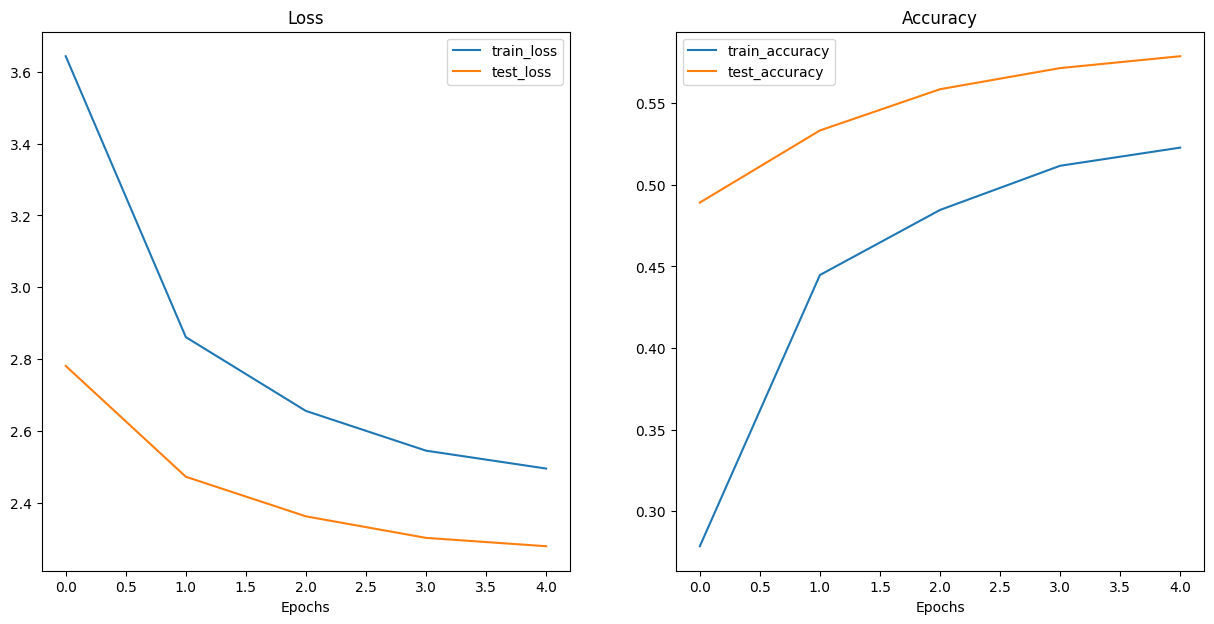

In [83]:
from helper_functions import plot_loss_curves

plot_loss_curves(food101_results)

### 10.7 Save and load FoodVision Big Model

In [84]:
from going_modular.going_modular.utils import save_model

# Create model path
effnetb2_food101_model_path = 'pretrained_effnetb2_feature_extractor_food101_20_percent.pth'

# Save model
save_model(
    model=effnetb2_food101,
    target_dir='models',
    model_name=effnetb2_food101_model_path
)

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [85]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(
    num_classes=101,
)

# Load the saved model's weights
loaded_effnetb2_food101.load_state_dict(torch.load('models/'+effnetb2_food101_model_path))

<All keys matched successfully>

### 10.8 Checking FoodVsion Big Model Size

In [86]:
from pathlib import Path

loaded_effnetb2_food101_size = Path('models/'+effnetb2_food101_model_path).stat().st_size / (1024 ** 2)
print(f'Loaded EffNetB2 FoodVision Big size: {loaded_effnetb2_food101_size:.1f} MB')

Loaded EffNetB2 FoodVision Big size: 30.4 MB


## 11. Truning FoodVision Big model into deployable app

Why deploy a model?

Deploying a model allows one to see how the model works in the real world, the best test set


By the end the file structure should look like:

``` python
demos/
└── foodvision_big/
    ├── pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    ├── app.py # Default python app which will be deployed
    ├── class_names.txt
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py # Model architecture and loading
    └── requirements.txt
```

In [87]:
from pathlib import Path

# Create foodvision big demo path
foodvision_big_demo_path = Path('demos/foodvision_big/')

# Make FoodVsiion Big directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVsiion Big exmaples directory
(foodvision_big_demo_path / 'examples').mkdir(parents=True, exist_ok=True)

In [88]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading an example image and moving it to the `examples` directory

In [89]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-12-18 05:59:04--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2025-12-18 05:59:05 (60.1 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)

Let's save all of the classes in Food101 to a .txt file so we can import and use them within the app

In [90]:
# Checkout the first few class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [91]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / 'class_names.txt'
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [92]:
# Write Food101 class names to text files
with open(foodvision_big_class_names_path, 'w') as f:
  print(f'[INFO] Saving Food101 class names to {foodvision_big_class_names_path}')
  f.write('\n'.join(food101_class_names)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [93]:
# open Food101 class names and read each line into a list
with open(foodvision_big_class_names_path, 'r') as f:
  food101_class_name_loaded = [food.strip() for food in f.readlines()]
food101_class_name_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [94]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=101,
                          seed:int=42):
  import torchvision
  from torchvision import models

  # Set seeds
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  # Get weights of model
  weights = models.EfficientNet_B2_Weights.DEFAULT

  # Get the transfroms
  effnetb2_transforms = weights.transforms()

  # Get model
  model = models.efficientnet_b2(weights=weights)

  # Freeze the feature layers
  for params in model.features.parameters():
    params.requires_grad = False

  # Replace classifier
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  #return the transfroms and the model
  return model, effnetb2_transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning the FoodVision Big Gradion app into a Python Script (`app.py`)

The `app.py` will have 4 major parts:
- Imports and class name setup (from the class name.text file)
- Model and transforms preparation (change the class list to match the food vision big)
- Predict function (`predict`)
- Gradio app - Gradio interface + launch command (Now change title and description)

In [96]:
%%writefile demos/foodvision_big/app.py
### 1. Import and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open('class_names.txt', r) as f:
  class_names = [food.stripe() for food in f.readlines()]

### 2. Model and transforms preparation ###

# Create model and transfroms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load the saved weight
effnetb2.load_state_dict(torch.load('pretrained_effnetb2_feature_extractor_food101_20_percent.pth'),
                         map_location=torch.device('cpu')) # mapt it to cpu as it was orginally trained on gpu

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  transformed_img = effnetb2_transforms(img).unsqueeze(0) # Add a batch dimension

  # Put model into eval mode, make prediction
  effnetb2.eval()

  with torch.inference_mode():
    pred_logits = effnetb2(transformed_img)
    pred_probs = pred_logits.softmax(dim=1)
    pred_label = pred_probs.argmax(dim=1)

  # Create a prediciton label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time-start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradion app ###

# Create title, description and article
title = 'FoodVision BIG 🍕🥩🍣'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as 101 classes of food from the Food101 dataset.'
article = 'Created as a part of PyTorch Course'

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Create the Gradio demo
demo = gr.Interface(
    fn=predict, # maps inpout to outputs
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=5, label='Predictions'),
            gr.Number(label='Predicion time (s)')], # Top 3 -> the order of them in the dataset
    examples=example_list,
    title=title,
    description=description,
    article=article,
    )

# Launch the demo
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)

In [97]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.9.0
torchvision==0.24.0
gradio==5.50.0

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [100]:
# Chane into the foodvision_mini directory and zip it from the inside
!cd demos/foodvision_big/ && zip -r ../foodvision_big.zip * -x '*.pyc' '*.ipynb' '*__pychache__*' '*ipynb_checkpoints*'

updating: app.py (deflated 53%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/04-pizza-dad.jpg (deflated 0%)
updating: model.py (deflated 53%)
updating: pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
updating: requirements.txt (deflated 6%)


In [101]:
# Download
try:
  from google.colab import files
  files.download('demos/foodvision_big.zip')
except:
  print(f'Not running in Google Colab, download it manually')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying FoodVision Big model app to HuggingFace Spaces

Let's bring FoodVision Big to life by deploying it to the world!!